In [4]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, LSTMCell
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import pickle as pkl
from tqdm import tqdm

In [5]:
import matplotlib.pyplot as plt

tfds.disable_progress_bar()
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [6]:
with open("../embeddings.pkl", "rb") as handle:
    embeddings_obj = pkl.load(handle)

with open("./labels.pkl", "rb") as handle:
    labels = pkl.load(handle)

In [7]:
with open("./seqs_dataset.pkl", "rb") as handle:
    seqs_dataset = pkl.load(handle)

In [8]:
seqs_dataset = pad_sequences(seqs_dataset, padding="post")

In [9]:
seqs_dataset = np.array(seqs_dataset)

In [10]:
BUFFER_SIZE = len(seqs_dataset)
BATCH_SIZE = 64

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((seqs_dataset, labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, 
                                                                                            drop_remainder=True) 

In [12]:
len(dataset)

1691

In [13]:
train_dataset = dataset.take(1352)
test_dataset = dataset.skip(1352)

In [14]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [[ 25765   4159 125882  22474   5040      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0]
 [150230      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0]
 [116324 116325 116324 116326 116324 115481 116324      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0]]

labels:  [0 1 0]


In [15]:
embeddings_obj["vocab_size"]

211842

In [16]:
VOCAB_SIZE = embeddings_obj["vocab_size"]

In [18]:
embedding_matrix = np.zeros((embeddings_obj["vocab_size"], 50))

for word, index in tqdm(embeddings_obj["vocab"].items()):
    embedding_matrix[index] = embeddings_obj["final_embeddings"][index]

100%|██████████| 211842/211842 [00:00<00:00, 360424.98it/s]


In [19]:
embedding_matrix[0]

array([-8.88911728e-03, -9.62603092e-03, -8.58380552e-03, -4.57175728e-03,
        3.06354277e-03,  1.61163323e-03,  8.65463726e-03, -1.41379610e-03,
       -1.77289732e-03, -1.13531109e-03, -4.35312511e-03, -2.00876035e-03,
        8.92821699e-03,  4.91806772e-03,  1.70095172e-03,  8.42242129e-03,
        3.77953239e-03, -2.01403629e-03, -4.26933030e-03, -5.57407364e-03,
        9.73564759e-03, -4.90249367e-03,  1.80886220e-03,  7.46479444e-03,
       -2.86419876e-03, -1.80834252e-03, -7.39332894e-03, -6.09712675e-04,
       -4.94124182e-03, -6.23500347e-03,  4.73371986e-03, -2.54590064e-04,
        2.03400850e-06, -3.49935051e-03, -1.94244087e-04,  2.74214894e-04,
       -5.96966501e-03,  5.77852689e-03,  3.06081958e-03, -1.10954791e-03,
       -7.35039916e-03, -2.20778212e-03,  8.04728083e-03, -2.28470797e-03,
       -3.66659882e-03, -6.69665355e-03, -1.39611680e-03, -7.58050429e-03,
        9.21327621e-03, -7.39899836e-03])

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 50, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [25]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True]


In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [29]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
  69/1352 [>.............................] - ETA: 4:03 - loss: 0.6575 - accuracy: 0.5881

KeyboardInterrupt: 

In [28]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

339/339 [==============================] - 5s 14ms/step - loss: 0.6624 - accuracy: 0.5749
Test Loss: 0.662350594997406
Test Accuracy: 0.5749446749687195


(0.0, 0.6688978910446167)

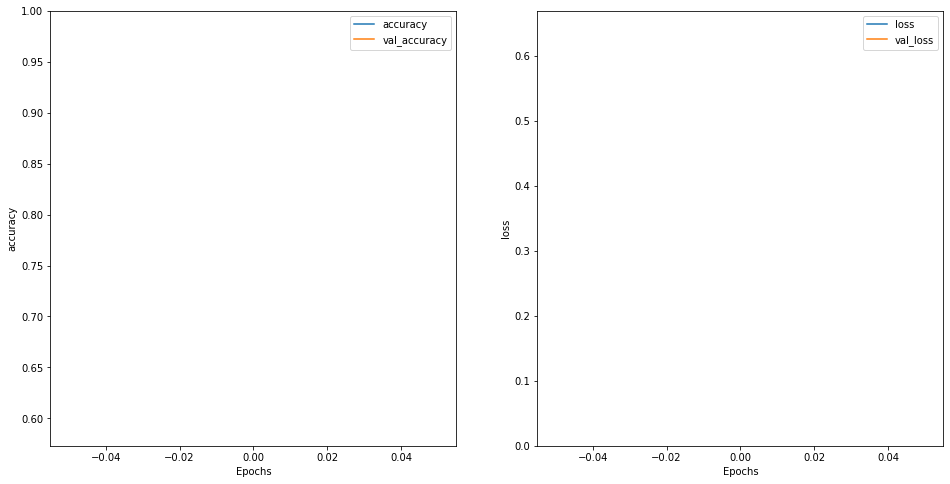

In [30]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [27]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

Exception ignored in: <function tqdm.__del__ at 0x14d55a1f0>
Traceback (most recent call last):
  File "/Users/alditopalli/.envs/python3_8/lib/python3.8/site-packages/tqdm/std.py", line 1143, in __del__
    self.close()
  File "/Users/alditopalli/.envs/python3_8/lib/python3.8/site-packages/tqdm/notebook.py", line 283, in close
    self.disp(bar_style='success')
AttributeError: 'tqdm' object has no attribute 'disp'


In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 50, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [34]:
history = model.fit(train_dataset, epochs=1,
                    validation_data=test_dataset,
                    validation_steps=30)

1352/1352 [==============================] - 294s 214ms/step - loss: 0.6800 - accuracy: 0.5661 - val_loss: 0.6659 - val_accuracy: 0.5651


In [35]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

339/339 [==============================] - 8s 22ms/step - loss: 0.6622 - accuracy: 0.5738
Test Loss: 0.6621547937393188
Test Accuracy: 0.5737923979759216


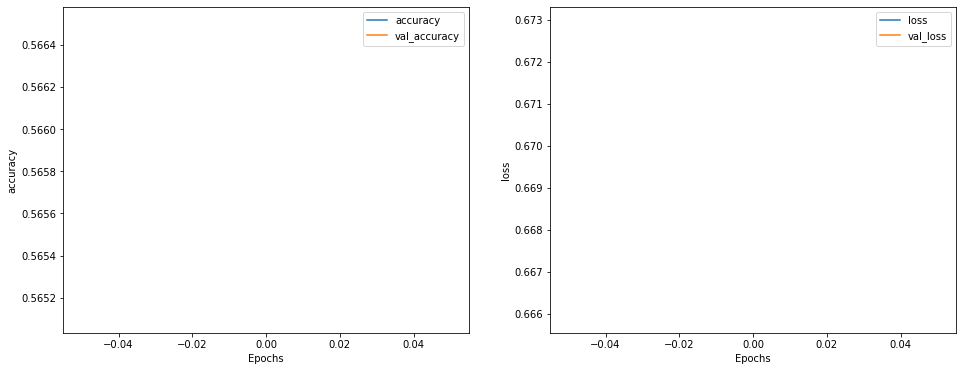

In [37]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')